In [14]:
import librosa as lr
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import ffmpeg
import mass_ts as mts
from scipy.fft import fft, ifft
import numpy as np
import soundfile as sf
from pydub import AudioSegment
from matrixprofile import matrixProfile
%matplotlib inline

In [103]:
x, sr = librosa.load('out.mp3', sr = 22050//10)

/home/will/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [104]:
prof = matrixProfile.scrimp_plus_plus(y, sr * 3, runtime=30)

/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:43: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(sigmax2)
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:215: RuntimeWarning: invalid value encountered in less
  update_pos1 = np.argwhere(tmp_a < tmp_b).flatten()
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:224: RuntimeWarning: invalid value encountered in less
  update_pos2 = np.argwhere(tmp_a < tmp_b).flatten()
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:112: RuntimeWarning: invalid value encountered in less
  update_pos = distance_profile < matrix_profile
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:275: RuntimeWarning: Max runtime exceeded. Approximate solution is given.
  RuntimeWarning


In [105]:
bad = x[sr * 27:sr*32]

In [106]:
bad = prof[0][sr * 27:sr*32]

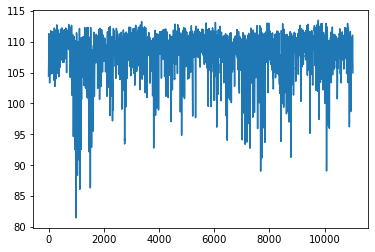

In [107]:
plt.plot(bad)

In [108]:
(bad < 50).sum()

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


0

In [43]:
np.mean(prof[0][1:])

nan

In [79]:
np.argwhere(np.isnan(prof[0]))

array([[     0],
       [  4134],
       [  8268],
       ...,
       [529152],
       [533286],
       [537420]])

In [83]:
mat_prof = prof[0]

In [84]:
prof_mean = np.mean(mat_prof[~np.isnan(mat_prof)])
prof_mean

167.99624530156436

In [85]:
is_under = (mat_prof < prof_mean)

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [112]:
def find_bad(seg, sr):
    prof = matrixProfile.scrimp_plus_plus(y, sr * 3, runtime=30)
    mat_prof = prof[0]
    prof_mean = np.mean(mat_prof[~np.isnan(mat_prof)])
    is_under = (mat_prof < prof_mean)
    out = []
    pers = []
    wind_sz = sr
    for i in range(len(is_under) - wind_sz):
        sec = is_under[i:i+wind_sz]
        cnt = sec.sum()
        percent_bad = cnt / wind_sz
        pers.append(percent_bad)
        out.append((cnt, i))

    per_mean = np.mean(pers)
    per_dev = np.std(pers)
    out_filt = [out[i] for i, per in enumerate(pers) if per > per_mean + 0.5 * per_dev]
#     for i, per in enumerate(pers):
#         if per > per_mean + 0.5 * per_dev:
#             out_filt.append(out[i])
    out_filt.sort(reverse=True)
    secs = []
    seen = set()
    for cnt, time in out_filt:
        rounded = int(np.round(time / sr))
        if rounded in seen:
            continue
        else:
            seen.add(rounded)
            secs.append(rounded)
    return secs

In [121]:
def into_intervals(bad_secs):
    secs_sorted = sorted(bad_secs)
    int_start = secs_sorted[0]
    last_int = secs_sorted[0]
    ints = []
    for i in range(1, len(secs_sorted)):
        curr = secs_sorted[i]
        if curr - last_int > 1:
            ints.append((int_start, last_int))
            int_start = curr
        last_int = curr
    ints.append((int_start, last_int))
    return ints

In [122]:
bad_idxs = find_bad(x, sr)

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [123]:
bad_ints = into_intervals(bad_idxs)

In [127]:
bad_ints

[(0, 1),
 (3, 4),
 (6, 17),
 (19, 22),
 (25, 28),
 (30, 37),
 (39, 43),
 (49, 51),
 (55, 56),
 (58, 60),
 (62, 62),
 (64, 66),
 (70, 70),
 (73, 75),
 (79, 81),
 (94, 96),
 (98, 99),
 (105, 105),
 (107, 108),
 (113, 118),
 (120, 120),
 (122, 125),
 (127, 131),
 (138, 139),
 (141, 143),
 (147, 152),
 (154, 156),
 (159, 163),
 (169, 172),
 (177, 177),
 (189, 191),
 (194, 195),
 (199, 204),
 (212, 215),
 (226, 231),
 (240, 243),
 (247, 248)]

In [128]:
def patch_audio(original, good, offset_dur, ints, new_sr):
    offset = int(np.round(offset_dur * new_sr))
    for st, end in ints:
        patch_len = (end - st) * new_sr
        original[st * new_sr:end * new_sr] = good[offset + st * new_sr:offset + end * new_sr]
    return original

In [96]:
out = []
pers = []
wind_sz = sr
for i in range(len(is_under) - wind_sz):
    sec = is_under[i:i+wind_sz]
    cnt = sec.sum()
    percent_bad = cnt / wind_sz
    pers.append(percent_bad)
    out.append((cnt, i))

out_filt = []
per_mean = np.mean(pers)
per_dev = np.std(pers)
for i, per in enumerate(pers):
    if per > per_mean + 0.5 * per_dev:
        out_filt.append(out[i])

In [97]:
out_filt.sort(reverse=True)

In [95]:
np.mean(pers), np.std(pers)

(0.3505275582158907, 0.37517494284404684)

In [98]:
secs = []
seen = set()
for cnt, time in out_filt:
    rounded = int(np.round(time / sr))
    if rounded in seen:
        continue
    else:
        seen.add(rounded)
        secs.append(rounded)

(array([6., 4., 5., 6., 7., 6., 6., 0., 3., 4.]),
 array([ 1. , 10.6, 20.2, 29.8, 39.4, 49. , 58.6, 68.2, 77.8, 87.4, 97. ]),
 <a list of 10 Patch objects>)

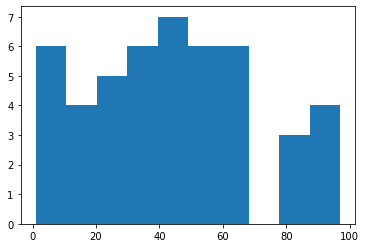

In [100]:
plt.hist(secs)

In [65]:
idxs = (np.argsort(out)[::-1])
secs = []
seen = set()
for idx in idxs:
    rounded = int(np.round(idx / sr))
    if rounded in seen:
        continue
    else:
        seen.add(rounded)
        secs.append(rounded)

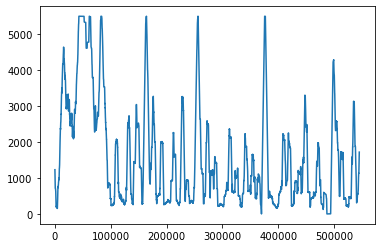

In [60]:
plt.plot(out)

In [37]:
okay = prof[0][sr*36:sr*41]

In [38]:
(okay<50).sum()

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


324

In [34]:
plt.plot(okay)

NameError: name 'okay' is not defined

/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:43: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(sigmax2)
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:215: RuntimeWarning: invalid value encountered in less
  update_pos1 = np.argwhere(tmp_a < tmp_b).flatten()
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:224: RuntimeWarning: invalid value encountered in less
  update_pos2 = np.argwhere(tmp_a < tmp_b).flatten()
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:112: RuntimeWarning: invalid value encountered in less
  update_pos = distance_profile < matrix_profile
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:442: RuntimeWarning: invalid value encountered in less
  loc1 = dist1 < matrix_profile
/home/will/anaconda3/lib/python3.7/site-packages/matrixprofile/scrimp.py:447: RuntimeWarning: invalid value encountered in less
  loc2 = dist2 < m

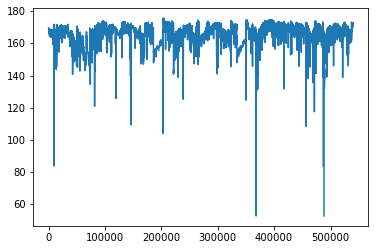

In [74]:
plt.plot(prof[0])

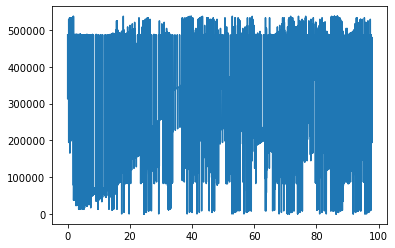

In [75]:
plt.plot(np.arange(0, len(prof[1]))/sr, prof[1])

ParameterError: Filter pass-band lies beyond Nyquist

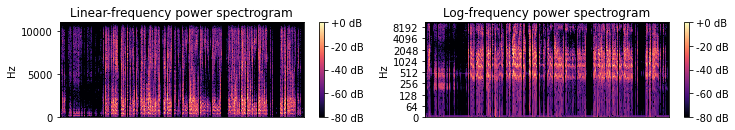

In [12]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
plt.subplot(4, 2, 3)
librosa.display.specshow(CQT, y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (note)')

plt.subplot(4, 2, 4)
librosa.display.specshow(CQT, y_axis='cqt_hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (Hz)')

C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

plt.subplot(4, 2, 6)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')


plt.subplot(4, 2, 7)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log power spectrogram')


plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()
plt.show()

/home/will/anaconda3/lib/python3.7/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


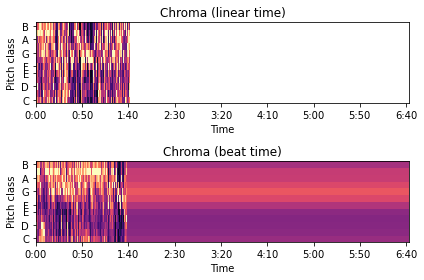

In [13]:
plt.figure()
tempo, beat_f = librosa.beat.beat_track(y=y, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',
                         x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()
plt.show()